In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
df1 = pd.read_csv('/content/gdrive/MyDrive/FPT/PNJ.csv')
df1


,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,PNJ,2/28/2018 9:15,78.14,78.99,78.14,78.99,270,0
1,PNJ,2/28/2018 9:16,78.94,78.94,78.94,78.94,10,0
2,PNJ,2/28/2018 9:19,78.14,78.14,78.14,78.14,283,0
3,PNJ,2/28/2018 9:20,78.14,78.14,78.14,78.14,480,0
4,PNJ,2/28/2018 9:21,78.14,78.14,78.14,78.14,146,0
...,...,...,...,...,...,...,...,...
125304,PNJ,12/22/2020 14:22,78.20,78.20,78.20,78.20,5000,0
125305,PNJ,12/22/2020 14:23,78.20,78.20,78.20,78.20,1700,0
125306,PNJ,12/22/2020 14:24,78.20,78.20,78.20,78.20,870,0
125307,PNJ,12/22/2020 14:25,78.10,78.10,78.10,78.10,13000,0


Phân tích biến động giá cổ phiếu dựa trên giá close cuối ngày

In [ ]:
df1 = df1[['Date/Time', 'Close']]


In [ ]:
def str_to_datetime1(s):
  sp = s.split(' ')[0]
  sp1 = s.split(' ')[1]

  split = sp.split('/')
  split1 = sp1.split(':')
 
  year, month, day,hour,minute = int(split[2]), int(split[0]), int(split[1]), int(split1[0]), int(split1[1])
  return datetime.datetime(year=year, month=month, day=day,hour=hour,minute=minute)

datetime_object1 = str_to_datetime1('12/25/2018 9:15')
datetime_object1

datetime.datetime(2018, 12, 25, 9, 15)

In [ ]:
df1['Date/Time'] = df1['Date/Time'].apply(str_to_datetime1)
df1['Date/Time']

<ipython-input-5-1c30a0f8f3cd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Date/Time'] = df1['Date/Time'].apply(str_to_datetime1)


0        2018-02-28 09:15:00
1        2018-02-28 09:16:00
2        2018-02-28 09:19:00
3        2018-02-28 09:20:00
4        2018-02-28 09:21:00
                 ...        
125304   2020-12-22 14:22:00
125305   2020-12-22 14:23:00
125306   2020-12-22 14:24:00
125307   2020-12-22 14:25:00
125308   2020-12-22 14:46:00
Name: Date/Time, Length: 125309, dtype: datetime64[ns]

In [ ]:
df1.index = df1.pop('Date/Time')

In [ ]:
import numpy as np
import time
from dateutil.relativedelta import relativedelta
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime1(first_date_str)
  last_date  = str_to_datetime1(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]
    # print(x,y)
    dates.append(target_date)
    X.append(x)
    Y.append(y)
    
    next = dataframe.loc[target_date:target_date+datetime.timedelta(hours=1,days=1)+relativedelta(years=1)]
    # print("next_week",next_week)
    next_datetime_str = str(next.head(2).tail(1).index.values[0])
    # print("next_datetime_str",next_week.head(2),"|",next_week.head(2).tail(1),"|",next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    next_hour_str = next_datetime_str.split('T')[1]
    # print("next_hour_str",next_hour_str)
    # print("next_date_str",next_date_str)
    hour_minute= next_hour_str.split(':')
    year_month_day = next_date_str.split('-')
    hour,minute,sc= hour_minute
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year),hour=int(hour),minute=int(minute))
    # print(next_date)
    if last_time:
      break
    # time.sleep(0.1)
    target_date = next_date
    
    if target_date == last_date:
      last_time = True
    # time.sleep(0.001)
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df1, 
                                '12/26/2018 9:18', 
                                '12/22/2020 14:46', 
                                n=10)
windowed_df

,Target Date,Target-10,Target-9,Target-8,Target-7,Target-6,Target-5,Target-4,Target-3,Target-2,Target-1,Target
0,2018-12-26 09:18:00,67.51,67.58,67.58,67.58,67.58,67.51,67.43,67.43,67.36,67.36,67.36
1,2018-12-26 09:21:00,67.58,67.58,67.58,67.51,67.43,67.43,67.36,67.36,67.36,67.87,67.94
2,2018-12-26 09:22:00,67.58,67.58,67.51,67.43,67.43,67.36,67.36,67.36,67.87,67.94,67.94
3,2018-12-26 09:23:00,67.58,67.51,67.43,67.43,67.36,67.36,67.36,67.87,67.94,67.94,67.58
4,2018-12-26 09:24:00,67.51,67.43,67.43,67.36,67.36,67.36,67.87,67.94,67.94,67.58,67.58
...,...,...,...,...,...,...,...,...,...,...,...,...
89847,2020-12-22 14:22:00,78.20,78.30,78.20,78.20,78.20,78.20,78.20,78.20,78.30,78.30,78.20
89848,2020-12-22 14:23:00,78.30,78.20,78.20,78.20,78.20,78.20,78.20,78.30,78.30,78.20,78.20
89849,2020-12-22 14:24:00,78.20,78.20,78.20,78.20,78.20,78.20,78.30,78.30,78.20,78.20,78.20
89850,2020-12-22 14:25:00,78.20,78.20,78.20,78.20,78.20,78.30,78.30,78.20,78.20,78.20,78.10


In [ ]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()
  
  dates = df_as_np[:,0]
 
  middle_matrix = df_as_np[:, 1:-1]

  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
  
  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((89852,), (89852, 10, 1), (89852,))

In [ ]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)
q_80, q_90, int(len(dates))

(71881, 80866, 89852)

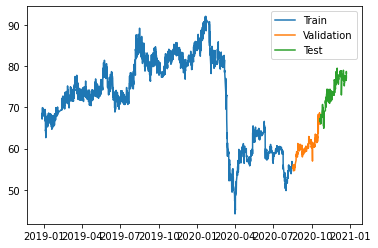

In [ ]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])




> Input layer


Input: Input layer có input shape là (X_train.shape[1], 1), điều này có nghĩa là nó mong đợi các chuỗi đầu vào có độ dài là X_train.shape[1] với một feature

> hidden layer


hidden layer: RNN có bốn hidden layer, mỗi lớp bao gồm một đơn vị SimpleRNN với hàm kích hoạt tanh. Tất cả các lớp SimpleRNN trừ lớp cuối cùng đều có tham số return_sequences được đặt thành True, chúng sẽ đưa ra một chuỗi các hidden states thay vì chỉ hidden states cuối cùng. Unit trong mỗi lớp SimpleRNN là 50( càng nhiều Unit có thể tăng khả năng của mô hình để bắt được các mẫu phức tạp trong dữ liệu đầu vào)

> Output layer


Output: Lớp đầu ra bao gồm một đơn vị dense duy nhất với hàm kích hoạt tuyến tính, điều này có nghĩa là nó sẽ tạo ra một giá trị đầu ra liên tục.

>compile



compile: Mô hình RNN được biên dịch với tối ưu hóa Adam với tốc độ học là 0.0001, và hàm mất mát là mean squared error (mse). Mô hình cũng theo dõi độ lỗi trung bình tuyệt đối (mean_absolute_error) làm chỉ số trong quá trình huấn luyện.

In [ ]:
# BUILD RNN

def Regressor():
 
  regressor = Sequential()

  regressor.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True, input_shape = (X_train.shape[1],1)))
  regressor.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True))
  regressor.add(SimpleRNN(units = 50,  activation = "tanh",  return_sequences = True) )
  regressor.add(SimpleRNN(units = 50) )
  regressor.add(Dense(units = 1))

  regressor.compile(
      optimizer = Adam(learning_rate=0.0001), 
      loss = "mse",
      metrics = ["mean_absolute_error"])
  return regressor
model= Regressor()
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10, 50)            2600      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 10, 50)            5050      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 10, 50)            5050      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 17,801
Trainable params: 17,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
checkpoint_path = "/content/gdrive/MyDrive/FPT/tensorflow/PNJ.h5"
# model.save(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,monitor='val_loss',
                                                  mode='min',
                                                  save_best_only=True)
model.load_weights(checkpoint_path)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs = 50, batch_size = 2247, callbacks=[cp_callback])

Epoch 1/50
32/32 [==============================] - ETA: 0s - loss: 0.3315 - mean_absolute_error: 0.3872
Epoch 1: val_loss improved from inf to 0.02522, saving model to /content/gdrive/MyDrive/FPT/tensorflow/PNJ.h5
32/32 [==============================] - 16s 245ms/step - loss: 0.3315 - mean_absolute_error: 0.3872 - val_loss: 0.0252 - val_mean_absolute_error: 0.1150
Epoch 2/50
32/32 [==============================] - ETA: 0s - loss: 0.2983 - mean_absolute_error: 0.3340
Epoch 2: val_loss improved from 0.02522 to 0.01710, saving model to /content/gdrive/MyDrive/FPT/tensorflow/PNJ.h5
32/32 [==============================] - 7s 213ms/step - loss: 0.2983 - mean_absolute_error: 0.3340 - val_loss: 0.0171 - val_mean_absolute_error: 0.0794
Epoch 3/50
32/32 [==============================] - ETA: 0s - loss: 0.2979 - mean_absolute_error: 0.3336
Epoch 3: val_loss did not improve from 0.01710
32/32 [==============================] - 7s 216ms/step - loss: 0.2979 - mean_absolute_error: 0.3336 - val_l

KeyboardInterrupt: ignored

DỰ ĐOÁN BIẾN ĐỘNG TRÊN LƯỢNG DATA ĐÃ TRAIN

---



2247/2247 [==============================] - 26s 11ms/step
[67.414825 67.480286 67.61683  ... 55.893944 55.848736 55.889816]


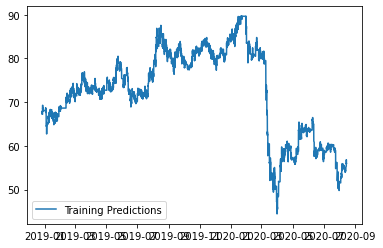

In [ ]:
train_predictions = model.predict(X_train).flatten()
print(train_predictions)
plt.plot(dates_train, train_predictions)

plt.legend(['Training Predictions'])


[67.36 67.94 67.94 ... 55.87 56.07 56.07]


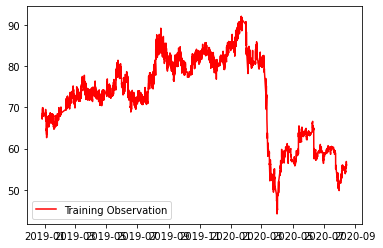

In [ ]:
plt.plot(dates_train, y_train,'r')
print(y_train)
plt.legend(['Training Observation'])

DỰ ĐOÁN TRÊN LƯỢNG DATA VALIDATION

281/281 [==============================] - 1s 4ms/step


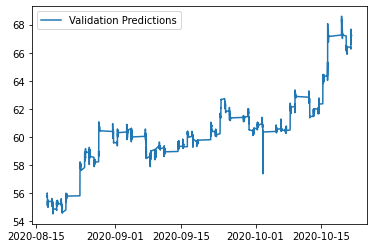

In [ ]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)

plt.legend(['Validation Predictions'])

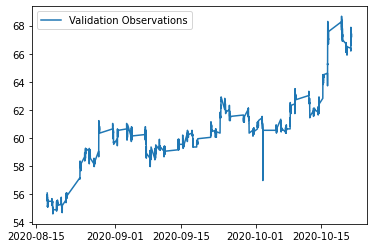

In [ ]:
plt.plot(dates_val, y_val)
plt.legend([ 'Validation Observations'])

281/281 [==============================] - 1s 4ms/step


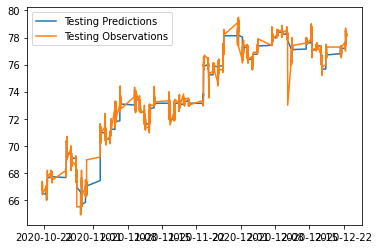

In [ ]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])